In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from scipy import signal

from matplotlib.pyplot import plot
import matplotlib.pyplot as plt
%matplotlib inline
%run 'tf.py'

In [2]:
# test wave
p_num = 1000
x = np.linspace(0, 1, p_num)

ten = np.linspace(0.2, 1, 10)
y = np.concatenate((ten, ten[::-1], ten, ten[::-1]))
y = np.tile(y, 25)

x, y = tf(x, y)

# plot_ekg(x, y)

In [3]:
# some health data fro QS app
hd = pd.read_csv('health_data.csv')
hd = hd.loc[:716]

hd['rcs'] = minmax_scale(hd['Resting Calories (kcal)'], (0.1, 1))
#plot(hd['rcs'], 'r-')

x, y = tf(hd.index, hd['rcs'])
#plot_ekg(x, y)

FileNotFoundError: [Errno 2] File health_data.csv does not exist: 'health_data.csv'

In [5]:
# extracted from svg by https://shinao.github.io/PathToPoints/
ekg = pd.read_csv('ekg.csv', names=['x', 'y'])
#plot_ekg(ekg.x, ekg.y)

In [5]:
ps = read_svg('./tf/ekg.svg', 1000)
#ps

set_xmlns_serif not found in:svg


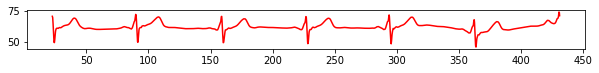

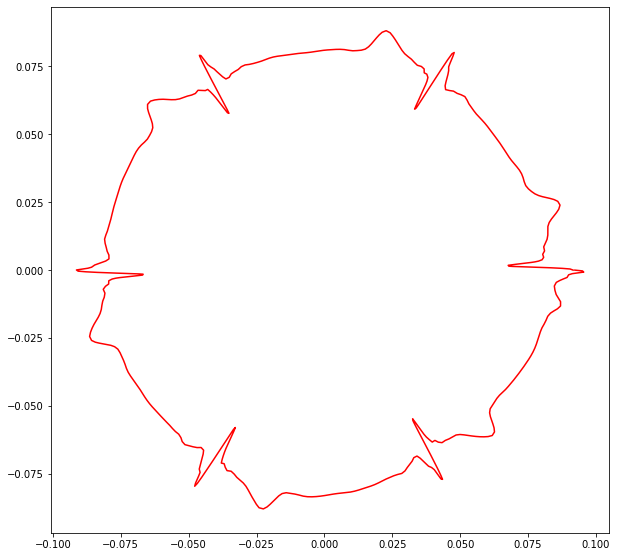

In [6]:
x, y = try_tf(ps.real, ps.imag, 25, 592, (0.4, 0.6))

In [8]:
xys = ps[25:592]
x, y = xys.real, xys.imag

x, y = tf(x, y, (0.4, 0.6))

# convert back to real+imag
z = np.zeros((len(x)), dtype=complex)
# scale by factor 5000
z.real, z.imag = x * 5000, y * 5000
# test if conversion was correct
#x, y = plot_ekg(z.real, z.imag)

# create new svg.path Path
new_path = Path()
# move to start
new_path.insert(0, Move(z[0]))

# insert points
for i, start, end in zip(range(1, len(z)-1), z[:-1], z[1:]):
    new_path.insert(i, Line(start, end))

# close path
new_path.insert(len(z), Line(z[-1], z[0]))
new_path.closed = True

# load old svg and edit to create circular one
f2 = pysvg.parser.parse('./tf/ekg.svg')

# get g
g = f2._subElements[0]
# remove transform
g.set_transform('')

# get path
p = g._subElements[0]
# set d in path Svg->G->Path
p.setAttribute('d', new_path.d())
# edit stroke-width
p.setAttribute('style', 'fill:none;fill-rule:nonzero;stroke:rgb(205,10,32);stroke-width:3px;')

# set viewBox
f2.setAttribute('viewBox', '-750 -750 1500 1500')

# save file
f2.save('./tf/new_path.svg')
    

set_xmlns_serif not found in:svg


In [16]:
## Spiral transformation


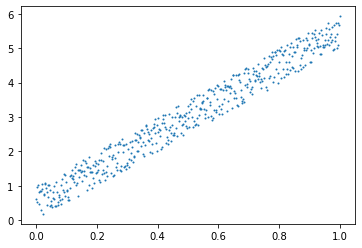

In [142]:
num = 500
t = np.linspace(0, 1, num)
#y = signal.sawtooth(2 * np.pi * 5 * t, width=0.5)
y = np.zeros(num)

y = y + np.random.random_sample((num,))

y = y + t * 5 * 1

plt.scatter(t, y, s=1)

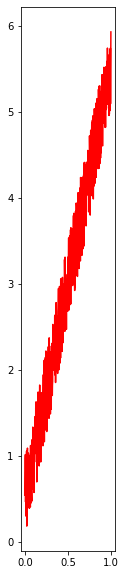

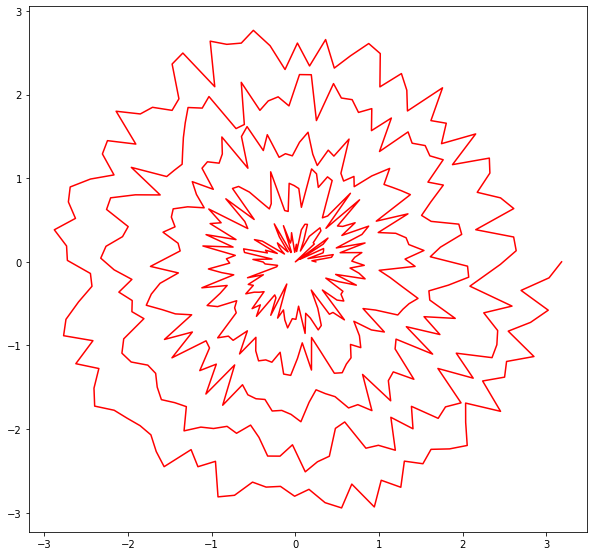

In [143]:
_, _ = try_tf_spiral(t, y, turns=5, start=0, x_scale=(0, 100), y_scale=(0, 100))


In [23]:
%run 'tf.py'

def shift_y(x, y, spacing_fac=5):
    return x, y + x # * spacing_fac

def move_circle(c, xmax, div_fac, turns=5, spacing_fac=0., x_offset=0., turn_dir=-1, angle_offset=0):
    cx = c.getAttribute('cx')
    cy = c.getAttribute('cy')

    nx, ny = shift_y(float(cx) + x_offset, float(cy), spacing_fac)
    x, y = tf_spiral_single(nx, ny, turns, xmax, turn_dir, angle_offset)

    c.setAttribute('cx', x / div_fac)
    c.setAttribute('cy', y / div_fac)
    return c

def move_line(l, xmax, div_fac, turns=5, spacing_fac=0, x_offset=0, turn_dir=-1, angle_offset=0):
    x1 = l.getAttribute('x1')
    y1 = l.getAttribute('y1')
    x2 = l.getAttribute('x2')
    y2 = l.getAttribute('y2')

    nx1, ny1 = shift_y(float(x1) + x_offset, float(y1), spacing_fac)
    nx2, ny2 = shift_y(float(x2) + x_offset, float(y2), spacing_fac)
    
    x1_t, y1_t = tf_spiral_single(nx1, ny1, turns, xmax, turn_dir, angle_offset)
    x2_t, y2_t = tf_spiral_single(nx2, ny2, turns, xmax, turn_dir, angle_offset)

    l.setAttribute('x1', x1_t / div_fac)
    l.setAttribute('y1', y1_t / div_fac)
    l.setAttribute('x2', x2_t / div_fac)
    l.setAttribute('y2', y2_t / div_fac)

    return l

def move_pline(pl, xmax, div_fac, turns=5, spacing_fac=0, x_offset=0, turn_dir=-1, angle_offset=0):
    points = pl.get_points()
    x1 = l.getAttribute('x1')
    y1 = l.getAttribute('y1')
    x2 = l.getAttribute('x2')
    y2 = l.getAttribute('y2')

    nx1, ny1 = shift_y(float(x1) + x_offset, float(y1), spacing_fac)
    nx2, ny2 = shift_y(float(x2) + x_offset, float(y2), spacing_fac)
    
    x1_t, y1_t = tf_spiral_single(nx1, ny1, turns, xmax, turn_dir, angle_offset)
    x2_t, y2_t = tf_spiral_single(nx2, ny2, turns, xmax, turn_dir, angle_offset)

    l.setAttribute('x1', x1_t / div_fac)
    l.setAttribute('y1', y1_t / div_fac)
    l.setAttribute('x2', x2_t / div_fac)
    l.setAttribute('y2', y2_t / div_fac)

    return l

def replace_move_line(l, rad, xmax, div_fac, turns=5, spacing_fac=0, x_offset=0, turn_dir=-1, angle_offset=0):
    pl = pysvg.shape.Polyline()
    pl.setAttribute('stroke-width', l.getAttribute('stroke-width'))
    pl.setAttribute('stroke', l.getAttribute('stroke'))
    
    # get start end end point of segment
    p1 = (float(l.getAttribute('x1')), float(l.getAttribute('y1')))
    p2 = (float(l.getAttribute('x2')), float(l.getAttribute('y2')))
    # get direction vector of segment
    v = (p2[0] - p1[0], p2[1] - p1[1])
    # get length of segment 
    length = math.sqrt(v[0] ** 2 + v[1] ** 2)
    
    # if line is shorter than radius
    if length <= rad:
        pl.set_points(f'{p1[0]},{p1[1]} {p2[0]},{p2[1]}')
        return pl

    # get normalized vector of segment
    v1 = (v[0] / length, v[1] / length)

    points = [p1]
    new_len = 0
    prev_p = p1
    while new_len < length:
        # check if rest of line is long enough to add rad
        if length >= new_len + rad:
            add = rad
        else:
            add = length - new_len

        # create new point with needed distance to previous one
        new_p = (prev_p[0] + v1[0] * add, prev_p[1] + v1[1] * add)
        new_len += add
        prev_p = new_p
        points.append(new_p)

    # move points
    nps = [shift_y(float(p[0]) + x_offset, float(p[1]), spacing_fac) for p in points]
    npm = [tf_spiral_single(p[0], p[1], turns, xmax, turn_dir, angle_offset) for p in nps]
    npd = [(p[0] / div_fac, p[1] / div_fac) for p in npm]

    def join_points(points):
        res = ""
        for p in points:
            res += f'{p[0]},{p[1]} '
        return res.strip(' ')

    pl.set_points(join_points(npd))
    return pl

def flatten(li):
    return [item for sublist in li for item in sublist]

In [11]:
f = pysvg.parser.parse('./svg/chart_reduced_ordering2.svg')
circle_group = f._subElements[0]
circles = f.getElementsByType(pysvg.shape.Circle)
line_group = f._subElements[1]
lines = f.getElementsByType(pysvg.shape.Line)
replace_line(lines[0])

In [29]:
f = pysvg.parser.parse('./svg/chart_reduced_4.svg')
circles = f.getElementsByType(pysvg.shape.Circle)

#line_group = f._subElements[1]
lines = f.getElementsByType(pysvg.shape.Line)

# load clear svg
f3 = pysvg.parser.parse('./svg/blank.svg')

rect = pysvg.Rect(x=-500, y=-500, width='100%', height='100%')
rect.setAttribute('style', 'fill:#363636')
f3.addElement(rect)

# get g
#g = f3._subElements[0]
# remove transform
#g.set_transform('')

# get path
#p = g._subElements[0]
# set d in path Svg->G->Path
#p.setAttribute('d', new_path.d())
# edit stroke-width
#p.setAttribute('style', 'fill:none;fill-rule:nonzero;stroke:rgb(205,10,32);stroke-width:3px;')

#pl_str = flatten([pl.get_points().split(' ') for pl in plines if type(pl) is pysvg.shape.Polyline])

xmax1 = max([float(c.getAttribute('cx')) for c in circles])
xmax2 = max([float(l.getAttribute('x1')) for l in lines])
xmax3 = max([float(l.getAttribute('x2')) for l in lines])
#xmax4 = max([float(pl.split(',')[0]) for pl in pl_str])
xmax = max([xmax1, xmax2, xmax3]) #, xmax4])

ymax1 = max([float(c.getAttribute('cy')) for c in circles])
ymax2 = max([float(l.getAttribute('y1')) for l in lines])
ymax3 = max([f10oat(l.getAttribute('y2')) for l in lines])
#ymax4 = max([float(pl.split(',')[1]) for pl in pl_str])
ymax = max([ymax1, ymax2, ymax3]) #, ymax4])

# 5 turns: 16
div_fac = 170
turns = 3
spacing_fac = 4
x_offset = xmax * 0.25
turn_dir = -1  # cw: 1, ccw: -1
angle_offset = np.pi * 0.5  # in radians

circle_group = pysvg.structure.G()
circle_group.setAttribute('stroke', '#fffdfa')
circle_group.setAttribute('stroke-width', '0.5')

for c in circles:
    circle = move_circle(c, xmax, div_fac, turns, spacing_fac, x_offset, turn_dir, angle_offset)
    circle_group.addElement(circle)

#for l in lines:
    #line = move_line(l, xmax, div_fac, turns, spacing_fac, x_offset, turn_dir, angle_offset)
    #line_group.addElement(line)

rad = 10.0
pline_group = pysvg.structure.G()
pline_group.setAttribute('fill', 'none')
plines = [replace_move_line(l, rad, xmax, div_fac, turns, spacing_fac, x_offset, turn_dir, angle_offset) for l in lines]

for pl in plines:
    #pline = move_pline(pl, xmax, div_fac, turns, spacing_fac, x_offset, turn_dir, angle_offset)
    pline_group.addElement(pl)

#f3.addElement(line_group)
f3.addElement(pline_group)
f3.addElement(circle_group)

# set viewBox
#f3.setAttribute('viewBox', '-500 -500 1000 1000')

# save file
f3.save('./svg/graph.svg')

set_xmlns_serif not found in:svg


NameError: name 'f10oat' is not defined

In [ ]:
![Graph](./svg/graph.svg)